# Hovercraft model

In [73]:
using JuMP, Gurobi, Mosek

    k = 4              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 50
    T[4] = 60

    # define waypoints
    xw = [ 1   4   6   1
           1   3   0   1 ]

function solveOpt(λ)
    # m = Model(solver = GurobiSolver(OutputFlag=0))
    m = Model(solver = MosekSolver(LOG=0))
    
    @variable(m, x[1:2,1:T[k]])  # resulting position
    @variable(m, v[1:2,1:T[k]])  # resulting velocity
    @variable(m, u[1:2,1:T[k]])  # thruster input

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== [0;0])

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end

    #=
    # hit all the waypoints
    for i in 1:k
        @constraint(m, x[:,T[i]] .== xw[:,i])
    end
    =#
    
    # hit the first waypoint only
    for i in 1
        @constraint(m, x[:,T[i]] .== xw[:,i])
    end
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    @objective(m, Min, sum(u.^2) + λ*sum( (x[:,T]-xw).^2 ) )
    solve(m)
    
    J1 = getvalue(sum(u.^2))
    J2 = getvalue(sum( (x[:,T]-xw).^2  ))
    xopt = getvalue(x)
    
    return (J1,J2,xopt)
end
;

## Plot trajectory

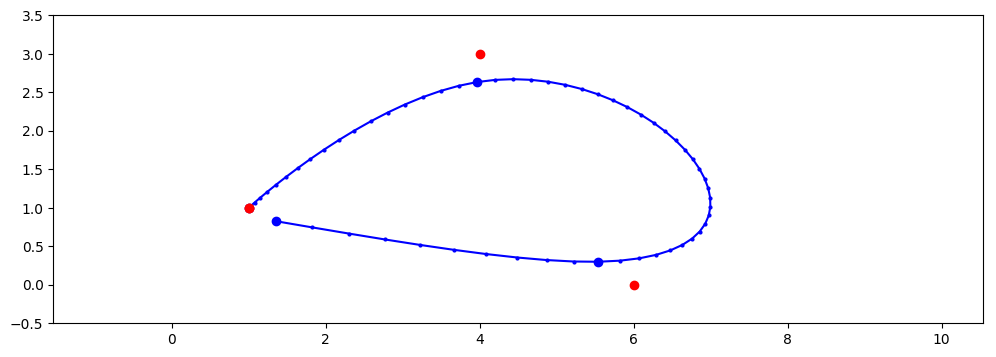

In [74]:
λ = 0.01
(J1x,J2x,x) = solveOpt(λ)

using PyPlot
figure(figsize=(12,4))
plot( x[1,:], x[2,:], "b.-", markersize=4 )
plot( x[1,:][T], x[2,:][T], "b.", markersize=12 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )
axis("equal")
axis((1.,8.,-.5,3.5));

## Compute tradeoff curve

In [67]:
Npts = 30
J1 = zeros(Npts)
J2 = zeros(Npts)
for (i,λ) in enumerate(logspace(-5,1,Npts))
    (J1[i],J2[i],uu) = solveOpt(λ)
end;

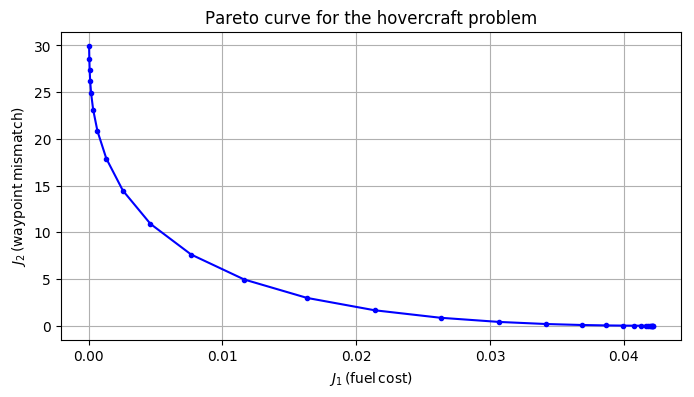

In [78]:
using PyPlot
figure(figsize=(8,4))
plot( J1, J2, "b.-" )
xlabel(L"J_1\, (\sf fuel\, cost)")
ylabel(L"J_2\, (\sf waypoint\, mismatch)");
title("Pareto curve for the hovercraft problem")
grid()